In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append("../")
from calc_Tsys import TskySim, auto_data
from scipy.optimize import curve_fit

/home/tcox/src/anaconda2/envs/HERA/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def curve_to_fit(Tsky_prime, g, n):
    return g*Tsky_prime+n

In [10]:
def build_model(sim, pols = ['E', 'N']):
    """
    Build model of Tsky that matches the data
    Args:
        sim: TskySim object with interpolation model already built
    """
    Tsky = np.zeros((len(pols), len(lsts), len(freqs)))
    Tsky_mean = np.zeros((len(pols), len(freqs)))
    
    for poli, pol in enumerate(pols):
        Tsky[poli, :, :] = Tsky_sim.mdl[pol](freqs, lsts).T
        Tsky_mean[poli, :] = Tsky[poli, :, :].mean(axis=0)
        
    return Tsky, Tsky_mean

In [16]:
nic_beam = '/data4/tcox/HERA_IDR2_analysis/HERA_Tsky_nic_beam_100_200.npz'
nic_sky = np.load(nic_beam)
lsts = nic_sky['lsts']
sky = nic_sky['HERA_Tsky']
freqs = nic_sky['freqs']
pols = ['X','Y']

In [17]:
Tsky_sim = TskySim(Tsky_file='HERA_Tsky_vivaldi.npz', f_min = 50.0, f_max = 250.0)
Tsky_sim.build_model()
Tsky_model, Tsky_mean = build_model(Tsky_sim)

In [18]:
sky.shape

(2, 100, 48)

In [19]:
Tsky_mean.shape

(2, 100)

In [52]:
noise = np.array([0,100,200,300,400,500])

auto_fits = np.zeros((noise.shape[0], len(pols), len(freqs), 2))
covs = np.zeros((noise.shape[0], len(pols), len(freqs), 2, 2))

for ni, n in enumerate(noise):
    for poli, pol in enumerate(pols):
        for fi, freq in enumerate(freqs):
            x = Tsky_model[poli,:,fi]-Tsky_mean[poli,fi]
            out = curve_fit(curve_to_fit, x, sky[poli, fi, :] + n, absolute_sigma=False)
            auto_fits[ni, poli, fi, :] = out[0]
            covs[ni, poli, fi, :, :] = out[1]
        

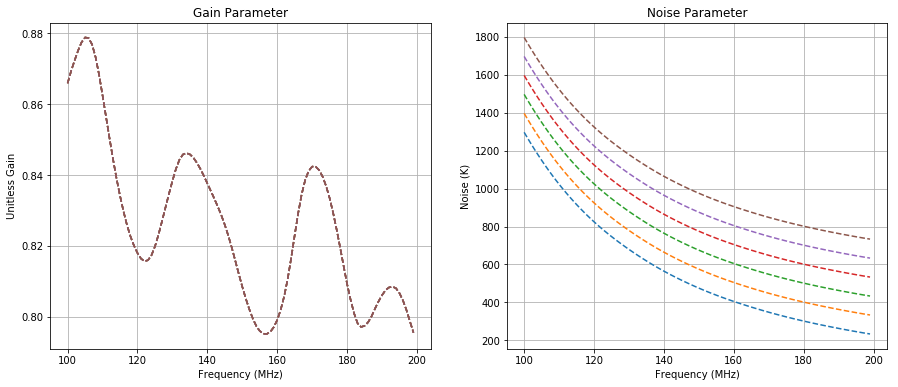

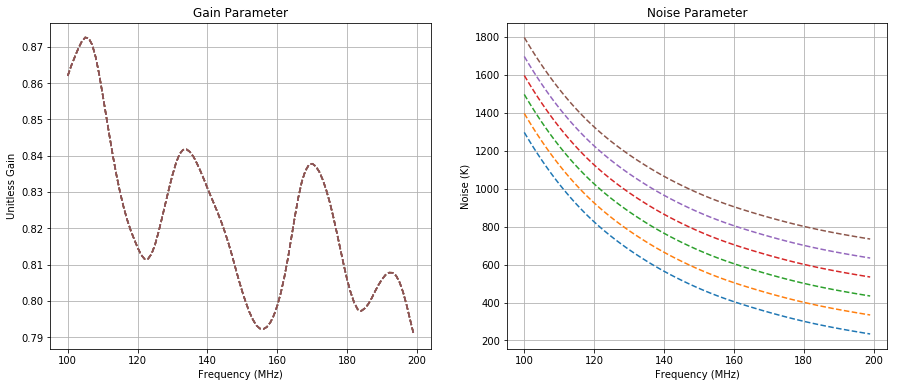

In [60]:
for poli, pol in enumerate(pols):
    fig, axs = plt.subplots(1, 2, figsize=(15,6))
    for i in np.arange(auto_fits.shape[0]):
        axs[0].plot(freqs, auto_fits[i, poli, :, 0], '--')
        axs[1].plot(freqs, auto_fits[i, poli, :, 1], '--')

    axs[0].set_xlabel('Frequency (MHz)')
    axs[0].set_title('Gain Parameter')
    axs[1].set_xlabel('Frequency (MHz)')
    axs[1].set_title('Noise Parameter')
    axs[0].grid()
    axs[1].grid()
    axs[0].set_ylabel('Unitless Gain')
    axs[1].set_ylabel('Noise (K)')
plt.show()

In [54]:
np.mean(auto_fits[-1, 0, :, 1] - auto_fits[0, 0, :, 1])

500.0000000559648

In [55]:
covs.shape

(6, 2, 100, 2, 2)

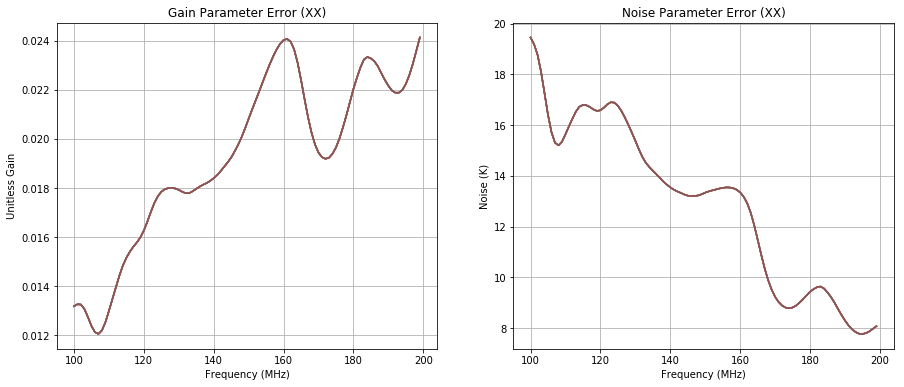

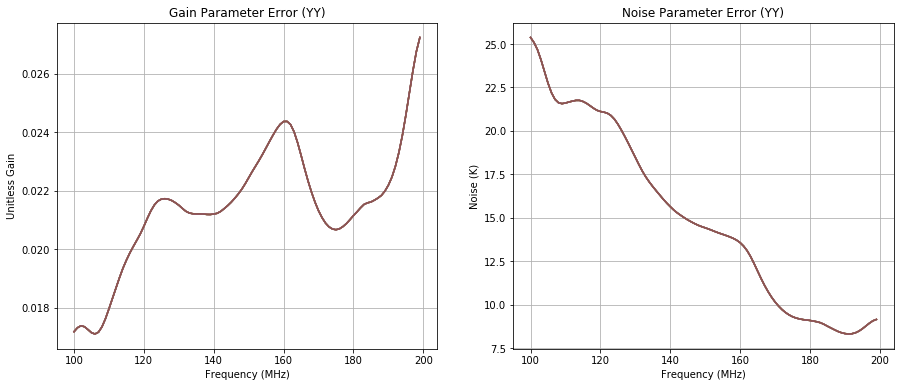

In [59]:
for poli, pol in enumerate(pols):
    fig, axs = plt.subplots(1, 2, figsize=(15,6))
    for ni, n in enumerate(noise):
        axs[0].plot(freqs, np.sqrt(covs[ni, poli, :, 0, 0]))
        axs[1].plot(freqs, np.sqrt(covs[ni, poli, :, 1, 1]))

    axs[0].set_xlabel('Frequency (MHz)')
    axs[0].set_title('Gain Parameter Error ({})'.format(pol*2))
    axs[1].set_xlabel('Frequency (MHz)')
    axs[1].set_title('Noise Parameter Error ({})'.format(pol*2))
    axs[0].grid()
    axs[1].grid()
    axs[0].set_ylabel('Unitless Gain')
    axs[1].set_ylabel('Noise (K)')
plt.show()

In [57]:
auto_fits.shape

(6, 2, 100, 2)

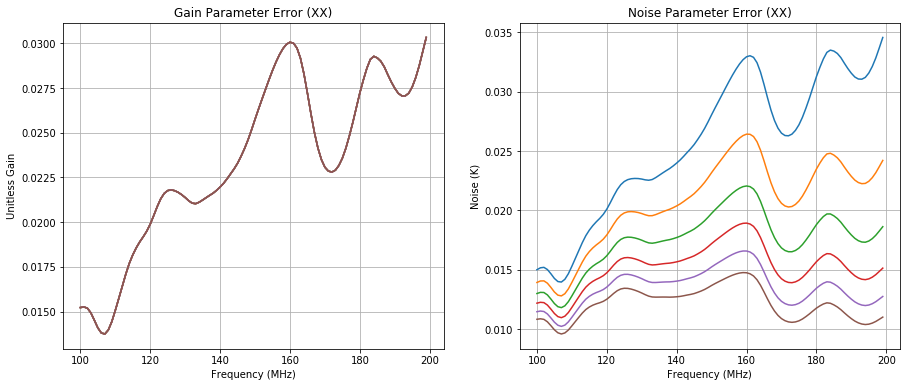

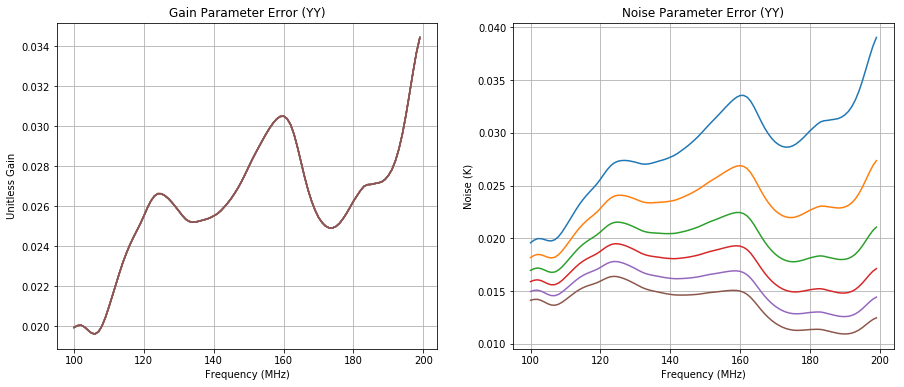

In [58]:
for poli, pol in enumerate(pols):
    fig, axs = plt.subplots(1, 2, figsize=(15,6))
    for ni, n in enumerate(noise):
        axs[0].plot(freqs, np.sqrt(covs[ni, poli, :, 0, 0]) /  auto_fits[ni, poli, :, 0])
        axs[1].plot(freqs, np.sqrt(covs[ni, poli, :, 1, 1]) /  auto_fits[ni, poli, :, 1])
    axs[0].set_xlabel('Frequency (MHz)')
    axs[0].set_title('Gain Parameter Error ({})'.format(pol*2))
    axs[1].set_xlabel('Frequency (MHz)')
    axs[1].set_title('Noise Parameter Error ({})'.format(pol*2))
    axs[0].grid()
    axs[1].grid()
    axs[0].set_ylabel('Unitless Gain')
    axs[1].set_ylabel('Noise (K)')
plt.show()